## SHAP values与PANSS items相关分析

### 1.分类诊断 模型


#### 1.仅EF，所有患者（包括错误预测的）

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import chi2_contingency
import warnings

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

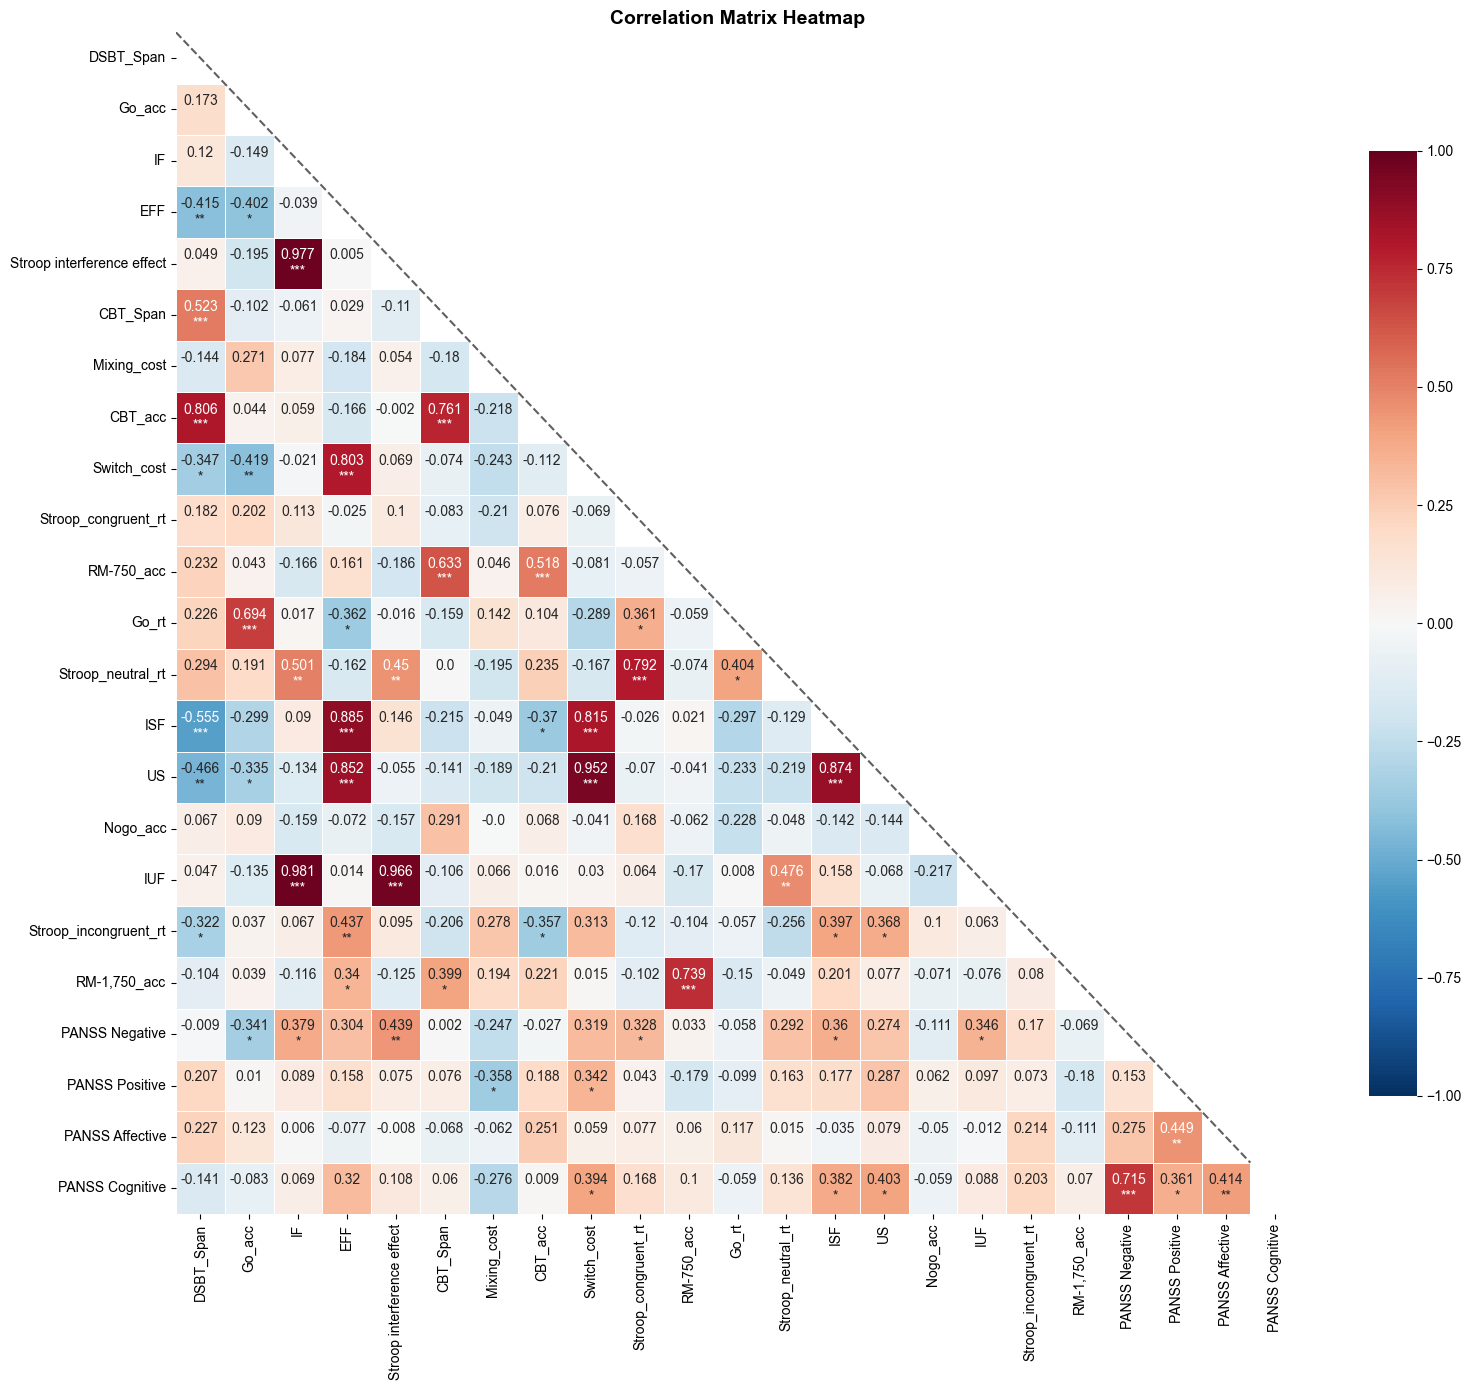

In [19]:
data = pd.read_excel('./SHAP_correlation_raw_data/分类诊断EF-所有患者（包括错误预测）.xlsx')


continuous_columns = ["DSBT_Span", "Go_acc", "IF", "EFF", "Stroop interference effect", "CBT_Span", 
                    "Mixing_cost", "CBT_acc", "Switch_cost", "Stroop_congruent_rt", "RM-750_acc", "Go_rt", "Stroop_neutral_rt", "ISF", "US", "Nogo_acc", 
                    "IUF", "Stroop_incongruent_rt", "RM-1,750_acc", 
                    "PANSS Negative", "PANSS Positive", "PANSS Affective", "PANSS Cognitive"]

#continuous_columns_original = ["DSBT_Span_orginal", "Go_acc_orginal", "IF_orginal", "EFF_orginal", "Stroop_interference effect_rt_orginal", "CBT_Span_orginal", "Mixing_cost_orginal", "CBT_acc_orginal", "Switch_cost_orginal", "Stroop_congruent_rt_orginal", "RM-750_acc_orginal", "Go_rt_orginal", "Stroop_neutral_rt_orginalt", "ISF_orginal", "US_orginal", "Nogo_acc_orginal", "IUF_orginal", "Stroop_incongruent_rt_orginal", "RM-1,750_acc_orginal"]



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd



corr = data[continuous_columns].corr()

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues = calculate_pvalues(data[continuous_columns])

def significance_level(pval):
    if pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return ''


labels = corr.round(3).astype(str) + '\n' + pvalues.applymap(significance_level)


mask = np.triu(np.ones_like(corr, dtype=bool))


np.fill_diagonal(corr.values, 0)

fig, ax = plt.subplots(figsize=(16, 14))


sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=labels, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10})

plt.plot(range(len(corr)), range(len(corr)), color='#606060', linestyle='dashed')
ax.set_title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./SHAP_correlation_result/分类诊断SHAP与基线PANSS的相关分析-仅EF-所有患者（包括错误预测的）.jpg", dpi=100, bbox_inches='tight')
plt.show()

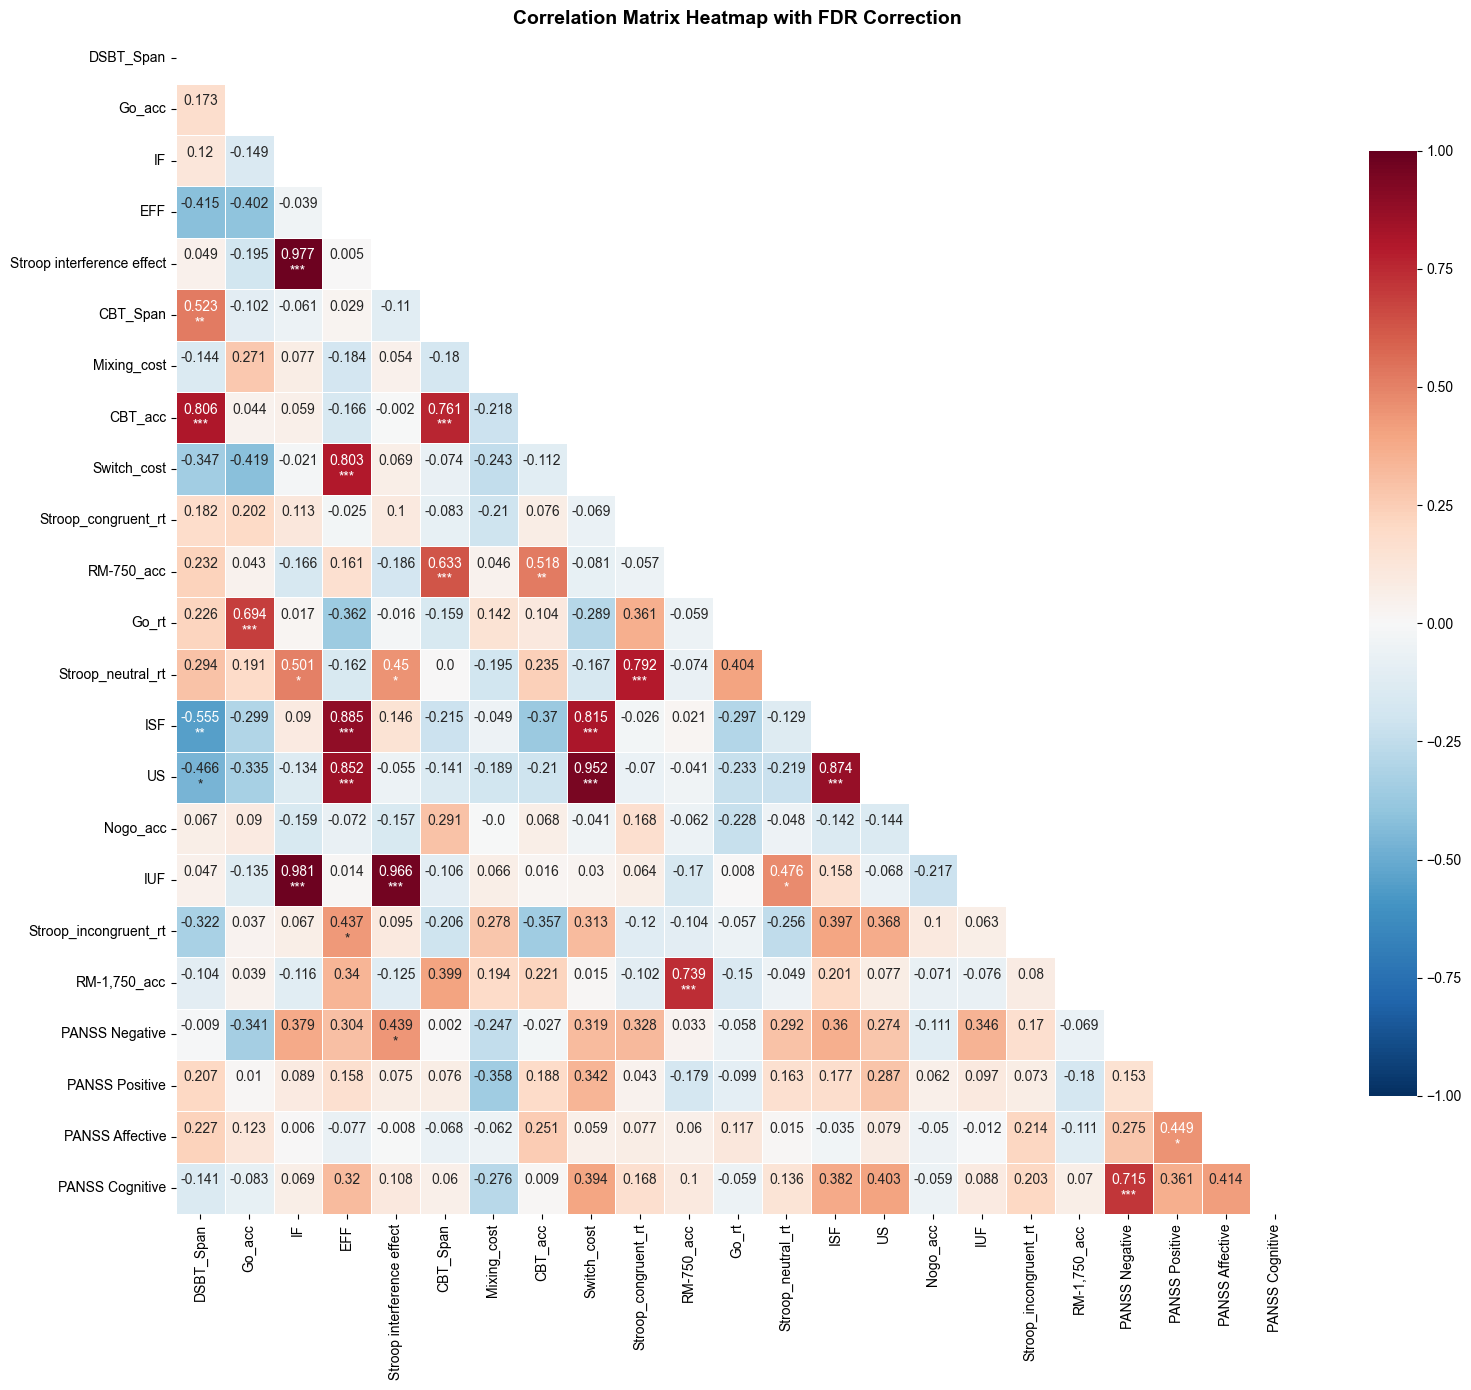

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

pvalues_numeric = pvalues.apply(pd.to_numeric, errors='coerce')

all_pvalues = pvalues_numeric.values.flatten()
all_pvalues = all_pvalues[~np.isnan(all_pvalues)]  

rej, pval_corr, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')


pval_corr_matrix = pd.DataFrame(np.reshape(pval_corr, pvalues.shape), columns=pvalues.columns, index=pvalues.index)


labels_corr = corr.round(3).astype(str) + '\n' + pval_corr_matrix.apply(lambda x: x.map(significance_level))

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=labels_corr, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10})
ax.set_title('Correlation Matrix Heatmap with FDR Correction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./SHAP_correlation_result/分类诊断SHAP与基线PANSS的相关分析-仅EF-所有患者（包括错误预测的）_FDR.jpg", dpi=100, bbox_inches='tight')
plt.show()

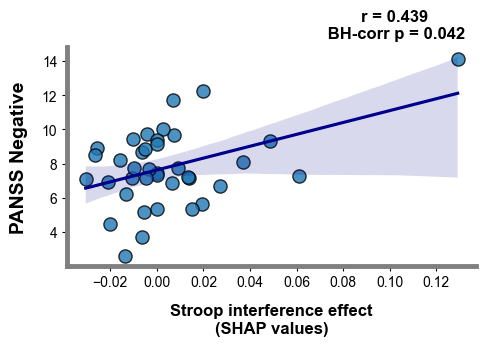

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr


variables_of_interest = ['PANSS Negative', 'PANSS Positive', 'PANSS Affective', 'PANSS Cognitive']

significant_vars = []

for var in variables_of_interest:
    significant_vars.extend(pval_corr_matrix.loc[(pval_corr_matrix[var] < 0.05) & (pval_corr_matrix.index != var), var].index.tolist())

significant_vars = list(set(significant_vars) - set(variables_of_interest))

num_plots = len(variables_of_interest) * len(significant_vars)
num_rows = 5  

fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))  
axes = axes.flatten()
plot_idx = 0

for var2 in variables_of_interest:
    for var1 in significant_vars:
        paired_data = data[[var2, var1]].dropna()

        corrected_p = pval_corr_matrix.loc[var1, var2]
        if corrected_p < 0.05:
            ax = axes[plot_idx]
            plot_idx += 1
            sns.regplot(
                x=paired_data[var1], 
                y=paired_data[var2],
                scatter_kws={'alpha': 0.8, 's': 90, 'edgecolor': 'k'}, 
                line_kws={'color': 'darkblue'}, 
                ci=95,  
                ax=ax  
            )
            r, _ = pearsonr(paired_data[var1], paired_data[var2]) 
            p_value_str = "p < 0.001" if corrected_p < 0.001 else f"p = {corrected_p:.3f}"

            xpos = 0.80
            ypos = 1.1

            ax.text(xpos, ypos, f'r = {r:.3f}\n BH-corr {p_value_str}', fontsize=12, weight='bold', ha='center', va='center', transform=ax.transAxes)
            ax.set_ylabel(var2, fontsize=14, weight='bold', labelpad=10)
            ax.set_xlabel(f"{var1}\n(SHAP values)", fontsize=12, weight='bold', labelpad=10)

            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)

            ax.spines['left'].set_linewidth(3.5)
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_linewidth(3.5)
            ax.spines['bottom'].set_color('grey')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig("./SHAP_correlation_result/散点图-诊断-EF-所有患者（包括错误预测的）_FDR.jpg", dpi=1000, bbox_inches='tight')
plt.show()

#### 2.EF+社会人口，所有患者（包括错误预测的）

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import chi2_contingency

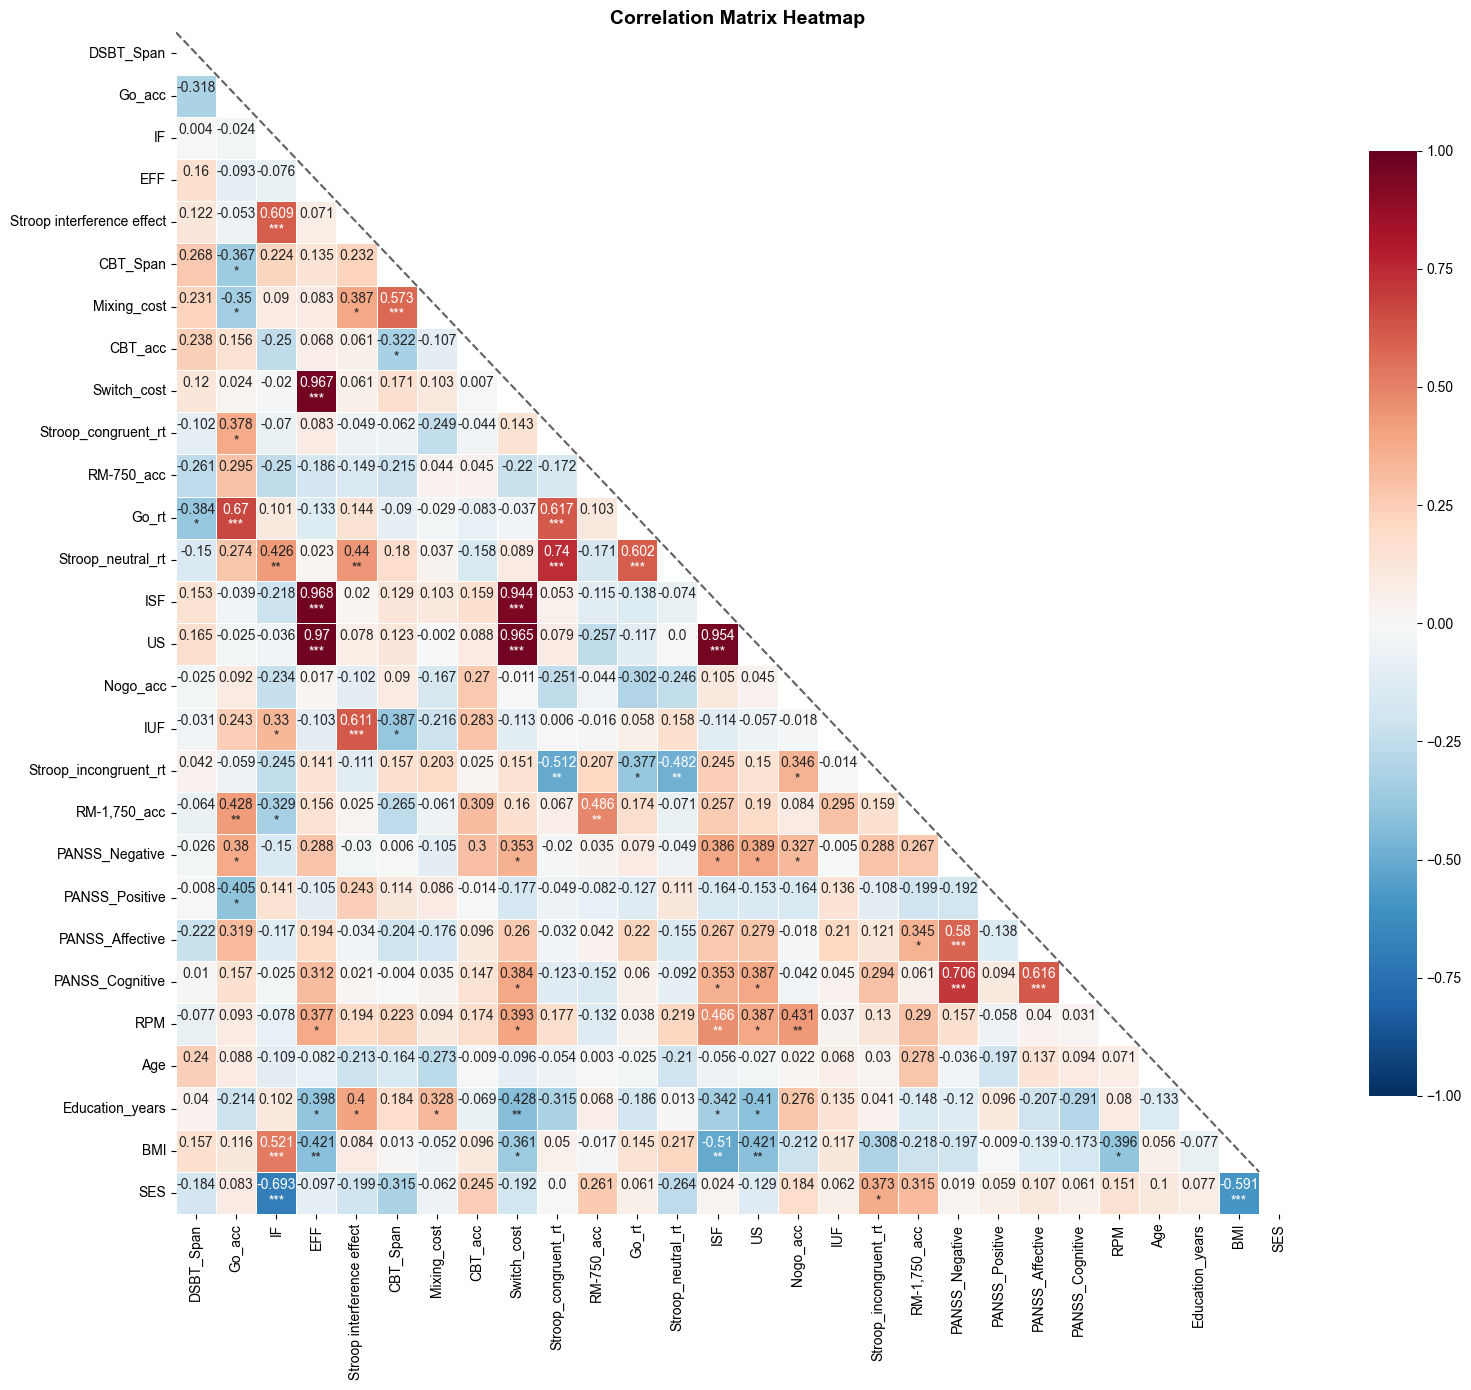

In [23]:
data = pd.read_excel('./SHAP_correlation_raw_data/分类诊断EF+人口-所有患者（包括错误预测|）.xlsx')


continuous_columns = ["DSBT_Span", "Go_acc", "IF", "EFF", "Stroop interference effect", "CBT_Span", 
                    "Mixing_cost", "CBT_acc", "Switch_cost", "Stroop_congruent_rt", "RM-750_acc", "Go_rt", "Stroop_neutral_rt", "ISF", "US", "Nogo_acc", 
                    "IUF", "Stroop_incongruent_rt", "RM-1,750_acc", 
                    "PANSS_Negative", "PANSS_Positive", "PANSS_Affective", "PANSS_Cognitive", 'RPM','Age', 'Education_years', 'BMI', 'SES']
#continuous_columns_original = ["DSBT_Span_orginal", "Go_acc_orginal", "IF_orginal", "EFF_orginal", "Stroop_interference effect_rt_orginal", "CBT_Span_orginal", 
                   # "Mixing_cost_orginal", "CBT_acc_orginal", "Switch_cost_orginal", "Stroop_congruent_rt_orginal", "RM-750_acc_orginal", "Go_rt_orginal", "Stroop_neutral_rt_orginalt", "ISF_orginal", "US_orginal", "Nogo_acc_orginal", 
                    #"IUF_orginal", "Stroop_incongruent_rt_orginal", "RM-1,750_acc_orginal"]


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd


corr = data[continuous_columns].corr()

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues = calculate_pvalues(data[continuous_columns])

def significance_level(pval):
    if pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return ''


labels = corr.round(3).astype(str) + '\n' + pvalues.applymap(significance_level)


mask = np.triu(np.ones_like(corr, dtype=bool))


np.fill_diagonal(corr.values, 0)

fig, ax = plt.subplots(figsize=(16, 14))


sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=labels, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10})

plt.plot(range(len(corr)), range(len(corr)), color='#606060', linestyle='dashed')
ax.set_title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./SHAP_correlation_result/分类诊断SHAP与基线PANSS的相关分析-EF+社会人口-所有患者（包括错误预测的）.jpg", dpi=100, bbox_inches='tight')
plt.show()

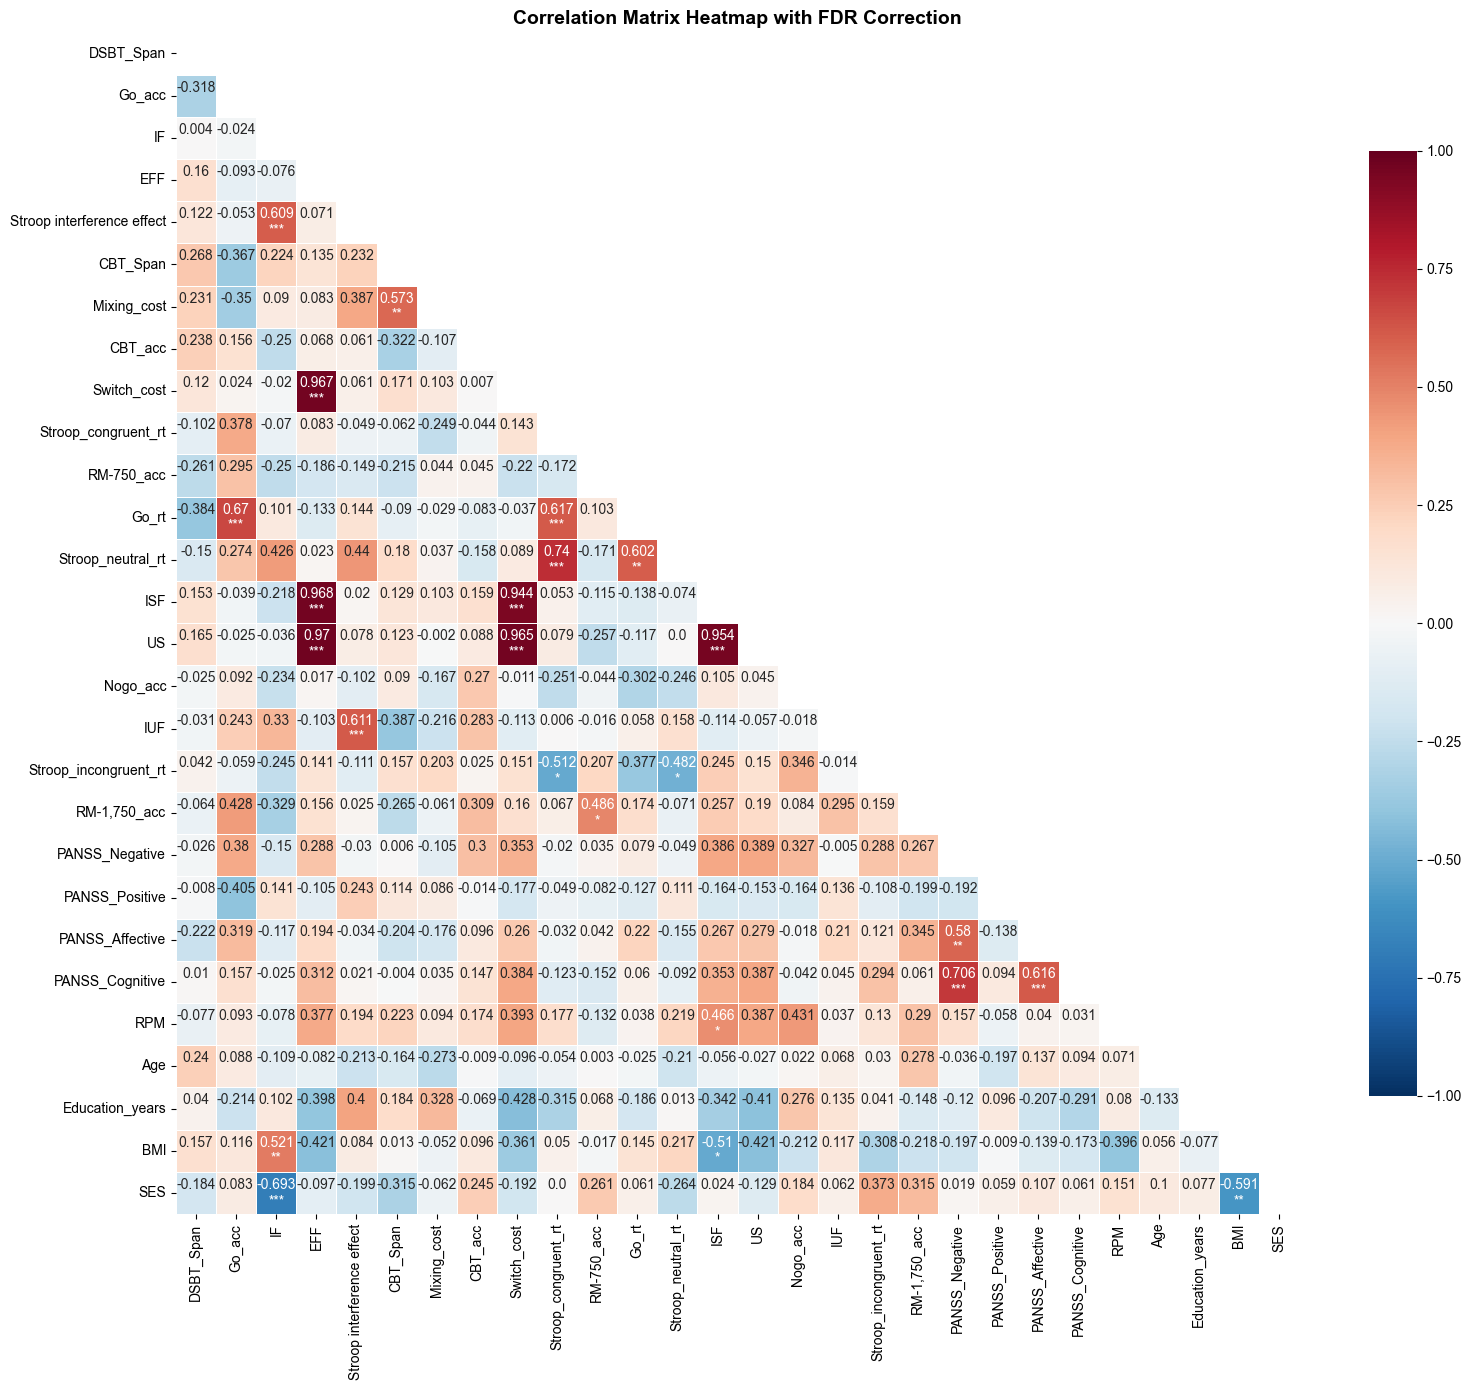

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

pvalues_numeric = pvalues.apply(pd.to_numeric, errors='coerce')

all_pvalues = pvalues_numeric.values.flatten()
all_pvalues = all_pvalues[~np.isnan(all_pvalues)]  

rej, pval_corr, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')


pval_corr_matrix = pd.DataFrame(np.reshape(pval_corr, pvalues.shape), columns=pvalues.columns, index=pvalues.index)


labels_corr = corr.round(3).astype(str) + '\n' + pval_corr_matrix.apply(lambda x: x.map(significance_level))

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=labels_corr, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10})
ax.set_title('Correlation Matrix Heatmap with FDR Correction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./results/分类诊断SHAP与基线PANSS的相关分析-EF+社会人口-所有患者（包括错误预测的）_FDR.jpg", dpi=100, bbox_inches='tight')
plt.show()

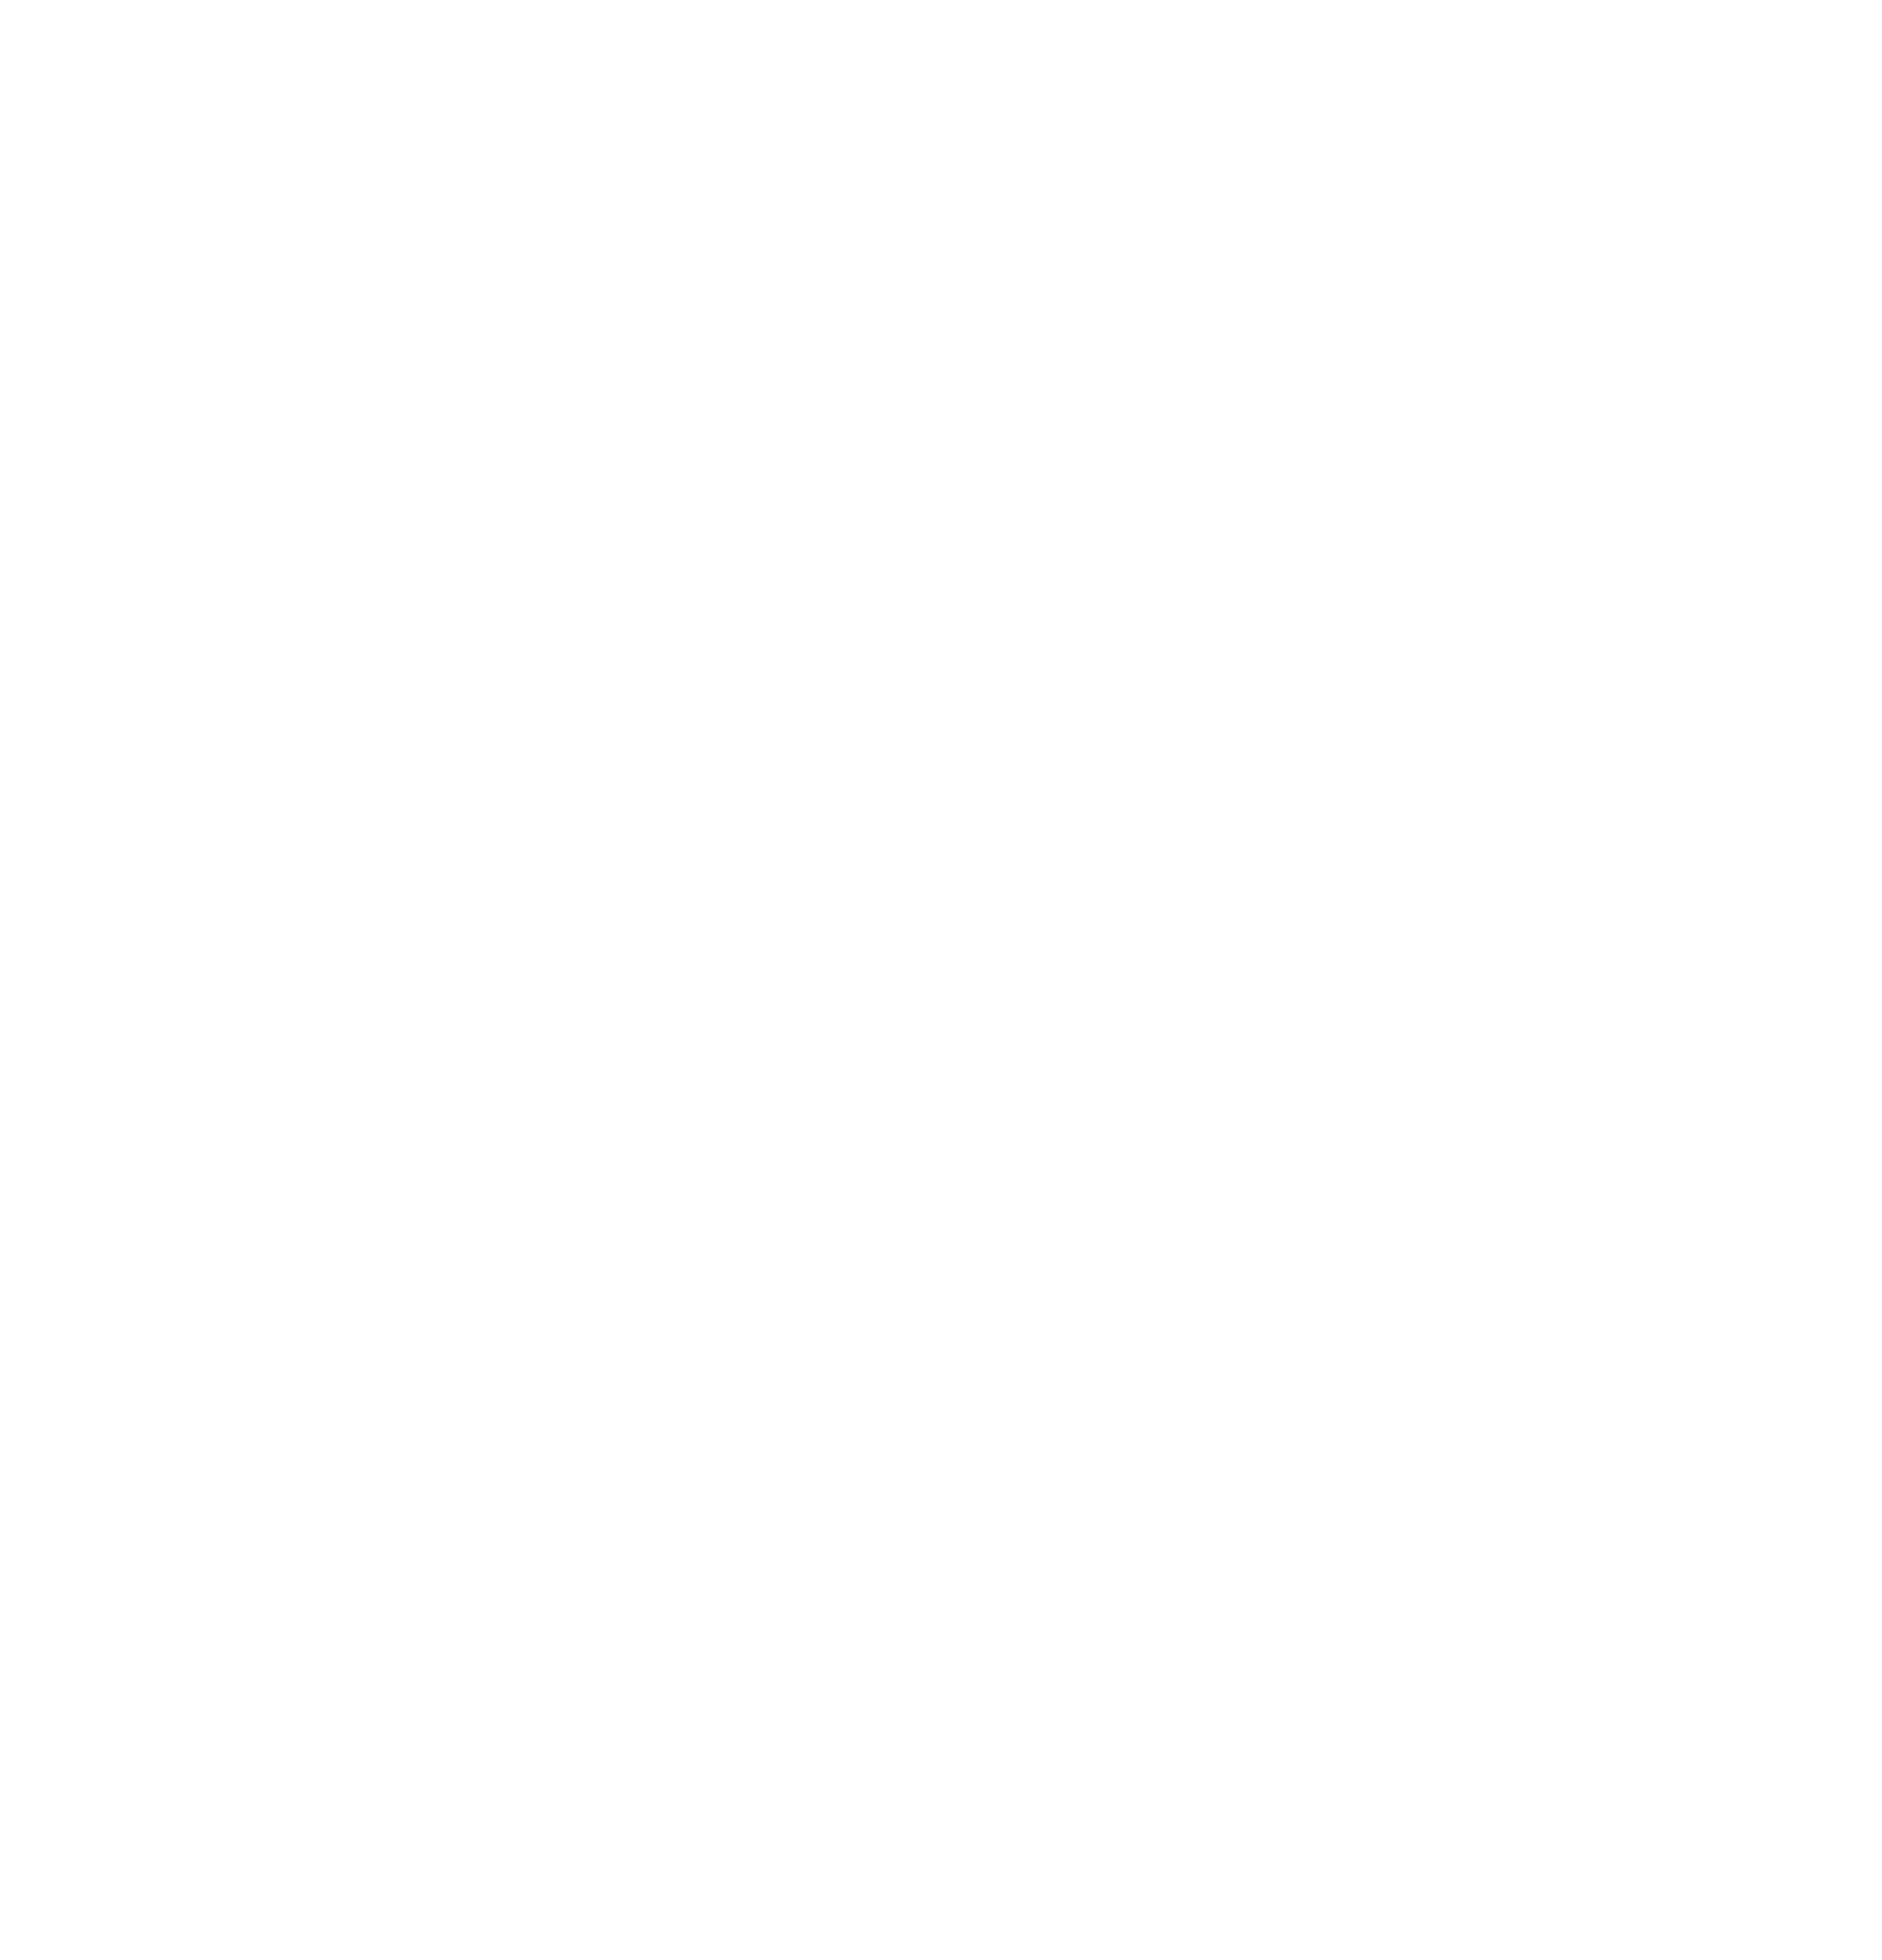

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr


variables_of_interest = ['PANSS_Negative', 'PANSS_Positive', 'PANSS_Affective', 'PANSS_Cognitive']

significant_vars = []

for var in variables_of_interest:
    significant_vars.extend(pval_corr_matrix.loc[(pval_corr_matrix[var] < 0.05) & (pval_corr_matrix.index != var), var].index.tolist())

significant_vars = list(set(significant_vars) - set(variables_of_interest))

num_plots = len(variables_of_interest) * len(significant_vars)
num_rows = 5  

fig, axes = plt.subplots(num_rows, 4, figsize=(24, num_rows * 5))  
axes = axes.flatten()
plot_idx = 0

for var2 in variables_of_interest:
    for var1 in significant_vars:
        paired_data = data[[var2, var1]].dropna()

        corrected_p = pval_corr_matrix.loc[var1, var2]
        if corrected_p < 0.05:
            ax = axes[plot_idx]
            plot_idx += 1
            sns.regplot(
                x=paired_data[var1], 
                y=paired_data[var2],
                scatter_kws={'alpha': 0.7, 's': 90, 'edgecolor': 'k'}, 
                line_kws={'color': 'darkblue'}, 
                ci=95,  
                ax=ax  
            )
            r, _ = pearsonr(paired_data[var1], paired_data[var2]) 
            p_value_str = "p < 0.001" if corrected_p < 0.001 else f"p = {corrected_p:.3f}"

            xpos = 0.80
            ypos = 1.05

            ax.text(xpos, ypos, f'r = {r:.3f}\n BH-corr {p_value_str}', fontsize=15, weight='bold', ha='center', va='center', transform=ax.transAxes)
            ax.set_ylabel(var2, fontsize=14, weight='bold', labelpad=10)
            ax.set_xlabel(f"{var1}\n(SHAP values)", fontsize=14, weight='bold', labelpad=10)

            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=12)

            ax.spines['left'].set_linewidth(3.5)
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_linewidth(3.5)
            ax.spines['bottom'].set_color('grey')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig("./SHAP_correlation_result/散点图-诊断-EF+社会人口-所有患者（包括错误预测的）_FDR.jpg", dpi=600, bbox_inches='tight')
plt.show()

### 2.预后分类

#### 3.EF和基线1、治疗后2，差值3 PANSS（仅EF，测试集所有样本,包括错误预测）

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import chi2_contingency


df = pd.read_excel('./SHAP_correlation_raw_data/预后-EF-所有样本.xlsx')

continuous_columns = ['Stroop incongruent reaction times', 'IUF', 'Stroop congruent reaction times', 'RM accuracy at 1,750 ms', 'Go_acc', 'CBT accuracy', 'Nogo_acc', 'Stroop_interference_effect_rt', 'CBT_Span', 'DSBT_Span', 'Go_rt', 'RM accuracy at 750 ms', 'EFF', 'Mixing_cost', 'Switch_cost', 'Stroop_neutral_rt', 'IF', 'ISF', 'US', 'PANSS Negative at baseline', 'PANSS Positive at baseline', 'PANSS Affective at baseline', 'PANSS Cognitive at baseline', 'PANSS Negative at follow-up', 'PANSS Positive at follow-up', 'PANSS Affective at follow-up', 'PANSS Cognitive at follow-up', 'PANSS-Negative-change', 'PANSS-Positive-change', 'PANSS-Affective-change', 'PANSS-Cognitive-change']

#continuous_columns_original = ["DSBT_Span_orginal", "Go_acc_orginal", "IF_orginal", "EFF_orginal", "Stroop_interference effect_rt_orginal", "CBT_Span_orginal", "Mixing_cost_orginal", "CBT_acc_orginal", "Switch_cost_orginal", "Stroop_congruent_rt_orginal", "RM-750_acc_orginal", "Go_rt_orginal", "Stroop_neutral_rt_orginalt", "ISF_orginal", "US_orginal", "Nogo_acc_orginal", "IUF_orginal", "Stroop_incongruent_rt_orginal", "RM-1,750_acc_orginal"]

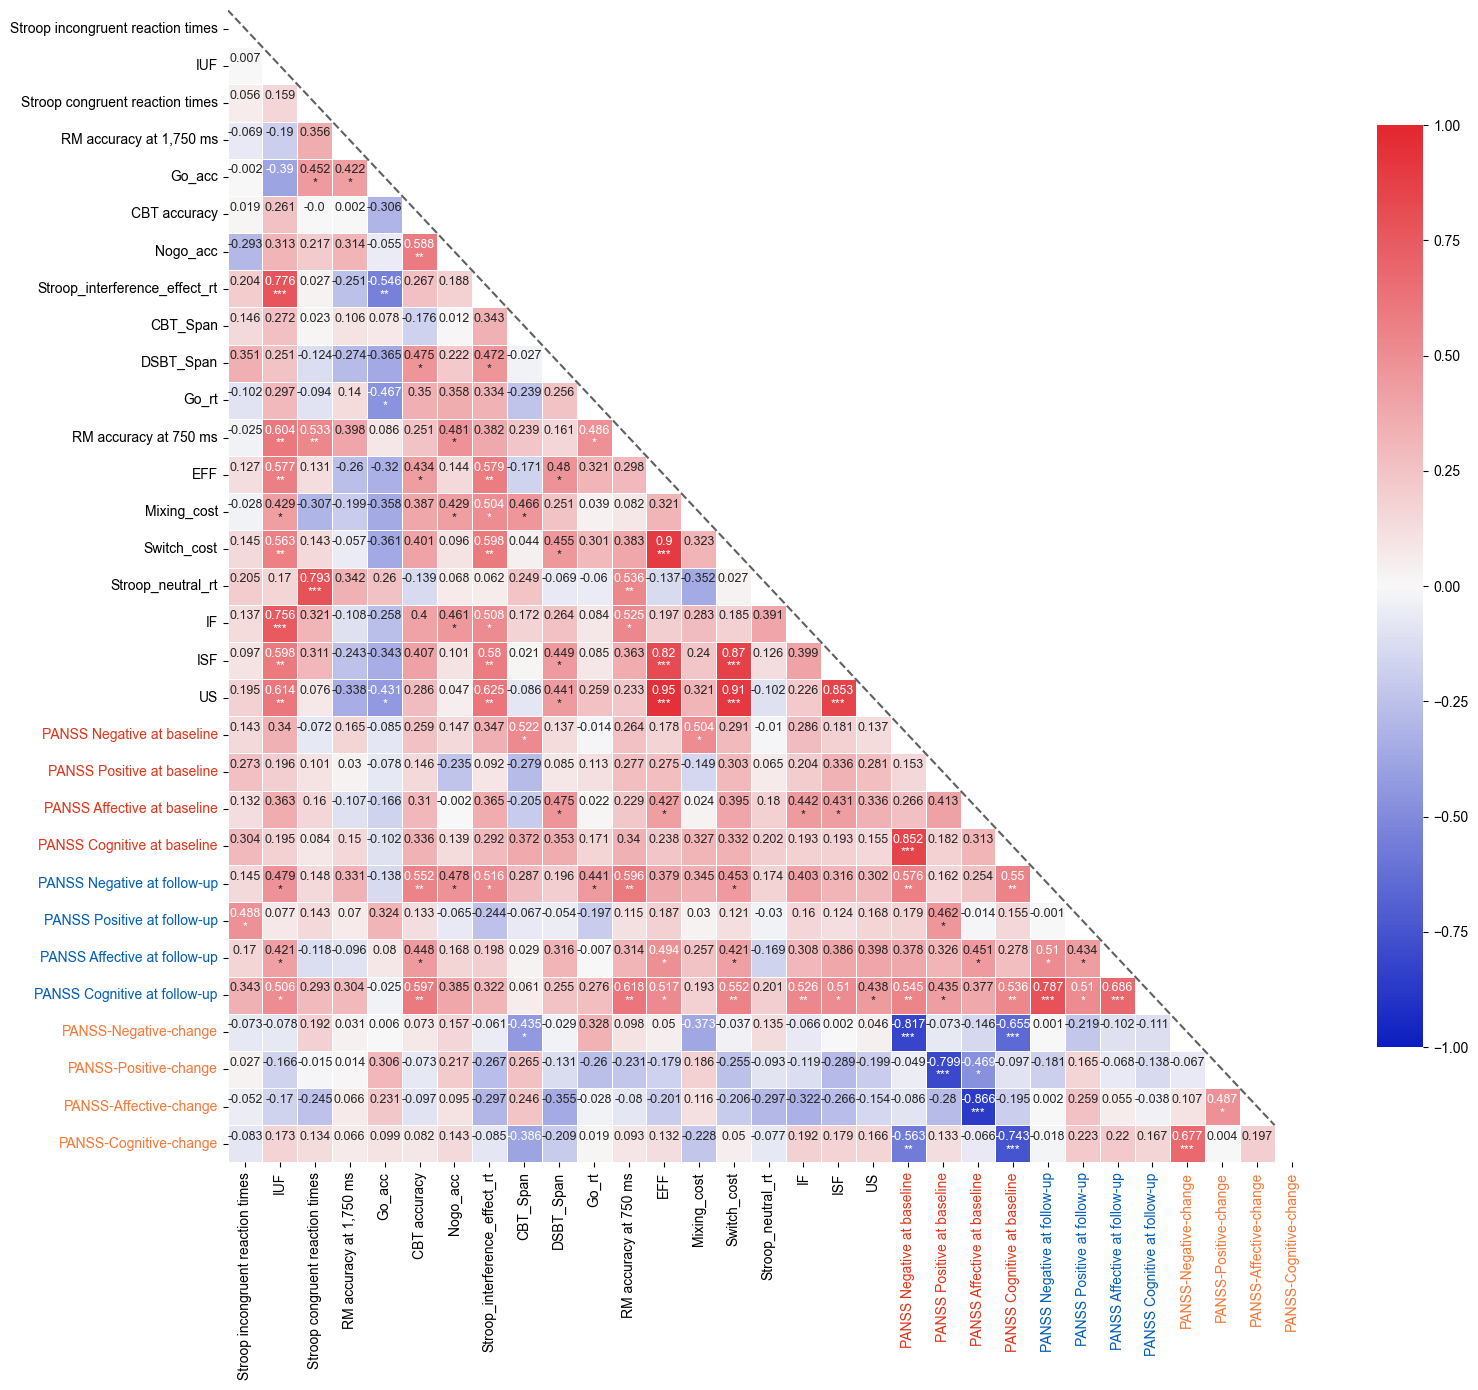

In [27]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

hex_colors_positive = ['#f7f7f7', '#E3262F']  
hex_colors_negative = ['#0C1EC1', '#f7f7f7']  
cmap_positive = LinearSegmentedColormap.from_list("Positive", hex_colors_positive, N=256)
cmap_negative = LinearSegmentedColormap.from_list("Negative", hex_colors_negative, N=256)

colors = np.vstack((cmap_negative(np.linspace(0, 1, 128)), cmap_positive(np.linspace(0, 1, 128))))
cmap_combined = LinearSegmentedColormap.from_list('Combined', colors)

data = df
corr = data[continuous_columns].corr()

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues = calculate_pvalues(data[continuous_columns])

def significance_level(pval):
    if pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return ''

labels = corr.round(3).astype(str) + '\n' + pvalues.applymap(significance_level)

mask = np.triu(np.ones_like(corr, dtype=bool))

np.fill_diagonal(corr.values, 0)

fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(corr, mask=mask, cmap=cmap_combined, center=0, annot=labels, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 9})


xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

def color_labels(labels):
    for label in labels:
        text = label.get_text()
        if text in ['PANSS Negative at baseline', 'PANSS Positive at baseline', 'PANSS Affective at baseline', 'PANSS Cognitive at baseline']:
            label.set_color('#E0341A') 
        elif text in ['PANSS Negative at follow-up', 'PANSS Positive at follow-up', 'PANSS Affective at follow-up', 'PANSS Cognitive at follow-up']:
            label.set_color('#005EB8') 
        elif text in ["PANSS-Negative-change",
    "PANSS-Positive-change",
    "PANSS-Affective-change",
    "PANSS-Cognitive-change"]:
            label.set_color('#F67737')  

color_labels(xticklabels)
color_labels(yticklabels)

plt.plot(range(len(corr)), range(len(corr)), color='#606060', linestyle='dashed')

plt.tight_layout()
plt.savefig("./SHAP_correlation_result/分类预后SHAP与基线PANSS的相关分析-预后-EF-所有样本.jpg", dpi=100, bbox_inches='tight')
plt.show()

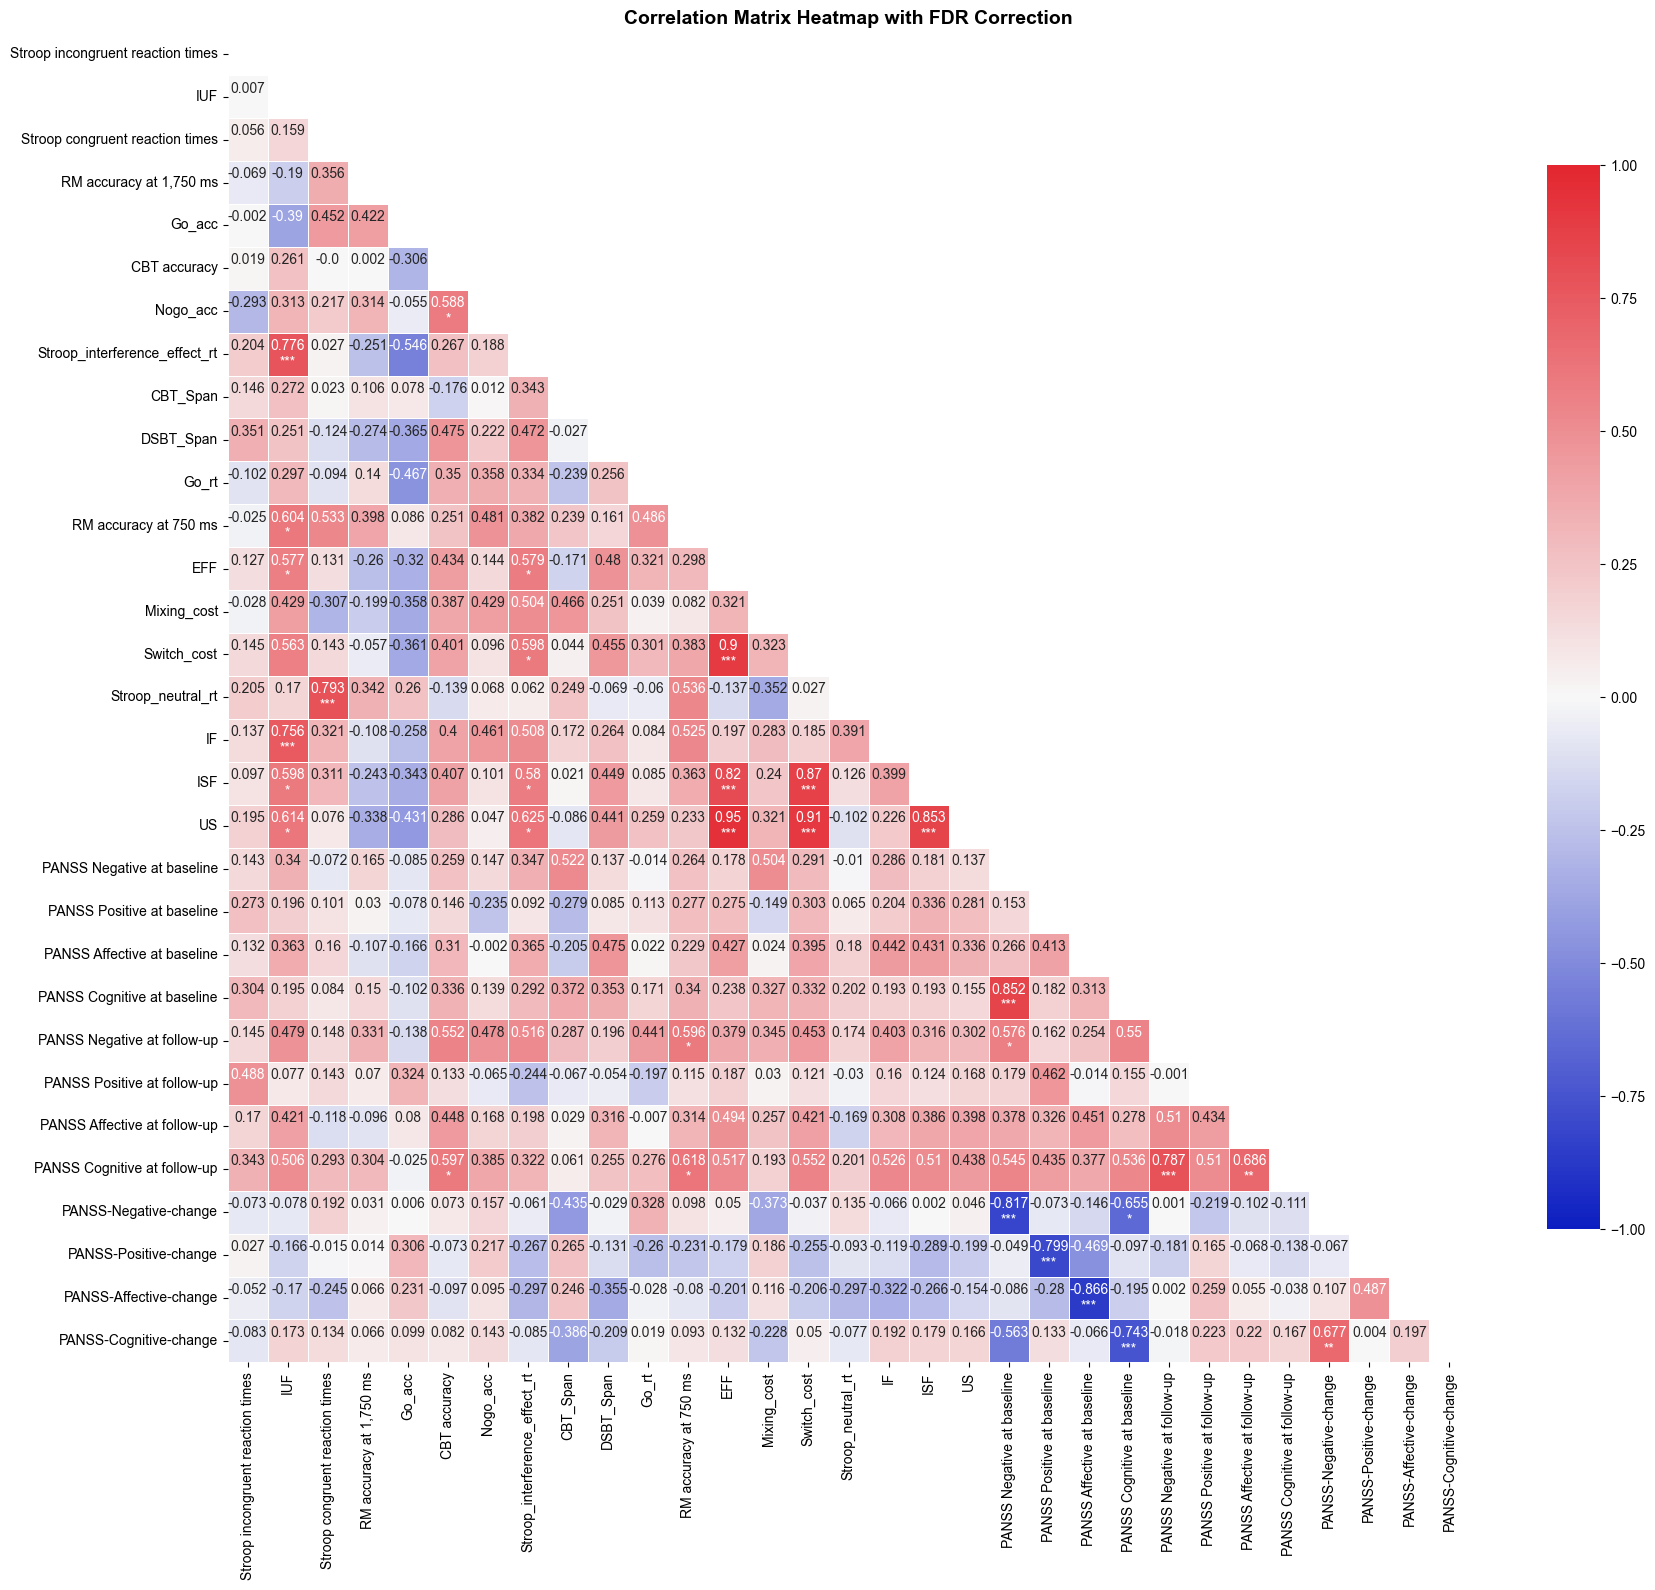

In [28]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

pvalues_numeric = pvalues.apply(pd.to_numeric, errors='coerce')

all_pvalues = pvalues_numeric.values.flatten()
all_pvalues = all_pvalues[~np.isnan(all_pvalues)]  

rej, pval_corr, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')


pval_corr_matrix = pd.DataFrame(np.reshape(pval_corr, pvalues.shape), columns=pvalues.columns, index=pvalues.index)


labels_corr = corr.round(3).astype(str) + '\n' + pval_corr_matrix.apply(lambda x: x.map(significance_level))

fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corr, mask=mask, cmap=cmap_combined, center=0, annot=labels_corr, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10})
ax.set_title('Correlation Matrix Heatmap with FDR Correction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./results/分类预后SHAP与基线PANSS的相关分析-预后-EF-所有样本_FDR.jpg", dpi=100, bbox_inches='tight')
plt.show()

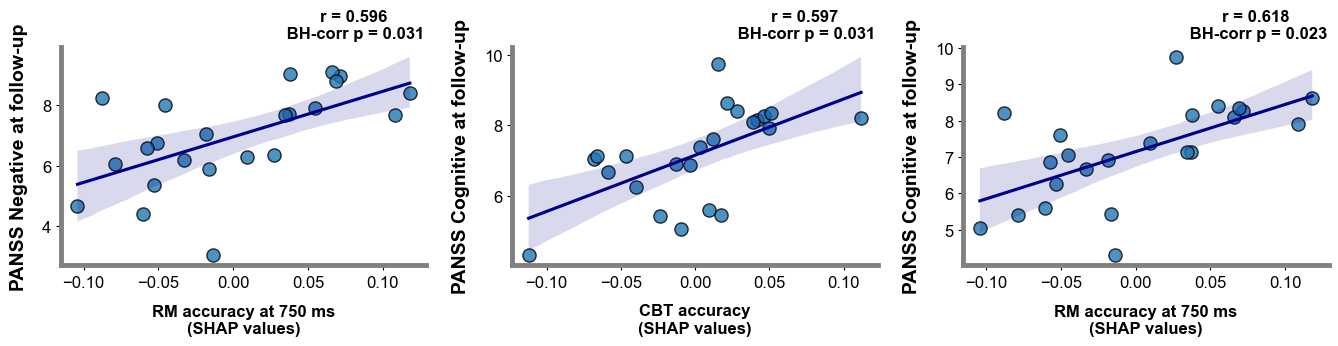

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

variables_of_interest =  ['PANSS Negative at baseline', 'PANSS Positive at baseline', 'PANSS Affective at baseline', 'PANSS Cognitive at baseline', 
                          'PANSS Negative at follow-up', 'PANSS Positive at follow-up', 'PANSS Affective at follow-up', 'PANSS Cognitive at follow-up',
    "PANSS-Negative-change",
    "PANSS-Positive-change",  
    "PANSS-Affective-change",
    "PANSS-Cognitive-change"]

significant_vars = []

for var in variables_of_interest:
    significant_vars.extend(pval_corr_matrix.loc[(pval_corr_matrix[var] < 0.05) & (pval_corr_matrix.index != var), var].index.tolist())

significant_vars = list(set(significant_vars) - set(variables_of_interest))

num_plots = len(variables_of_interest) * len(significant_vars)
num_rows = 5  

fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))  
axes = axes.flatten()
plot_idx = 0

for var2 in variables_of_interest:
    for var1 in significant_vars:
        paired_data = data[[var2, var1]].dropna()

        corrected_p = pval_corr_matrix.loc[var1, var2]
        if corrected_p < 0.05:
            ax = axes[plot_idx]
            plot_idx += 1
            sns.regplot(
                x=paired_data[var1], 
                y=paired_data[var2],
                scatter_kws={'alpha': 0.8, 's': 90, 'edgecolor': 'k'}, 
                line_kws={'color': 'darkblue'}, 
                ci=95,  
                ax=ax  
            )
            r, _ = pearsonr(paired_data[var1], paired_data[var2]) 
            p_value_str = "p < 0.001" if corrected_p < 0.001 else f"p = {corrected_p:.3f}"

            xpos = 0.8
            ypos = 1.1

            ax.text(xpos, ypos, f'r = {r:.3f}\n BH-corr {p_value_str}', fontsize=12, weight='bold', ha='center', va='center', transform=ax.transAxes)
            ax.set_ylabel(var2, fontsize=14, weight='bold', labelpad=10)
            ax.set_xlabel(f"{var1}\n(SHAP values)", fontsize=12, weight='bold', labelpad=10)

            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

            ax.spines['left'].set_linewidth(3.5)
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_linewidth(3.5)
            ax.spines['bottom'].set_color('grey')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig("./SHAP_correlation_result/散点图-预后-EF-所有样本（包括错误预测的）_FDR.jpg", dpi=1000, bbox_inches='tight')
plt.show()

#### 4.EF和基线1、治疗后2，差值3 PANSS（EF+社会人口，测试集所有样本,包括错误预测）

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import chi2_contingency


df = pd.read_excel('./SHAP_correlation_raw_data/预后-EF+人口-所有样本.xlsx')


continuous_columns = ['Stroop_incongruent_rt', 'Stroop congruent reaction times', 'Stroop_neutral_rt', 'Stroop_interference_effect_rt', 'Go accuracy in Go/Nogo task', 'Go_rt', 'Nogo_acc', 'Switch_cost', 'Mixing_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span', 'CBT_Span', 'CBT_acc', 'IF', 'EFF', 'IUF', 'ISF', 'US', 'PANSS Negative at baseline', 'PANSS Positive at baseline', 'PANSS Affective at baseline', 'PANSS Cognitive at baseline', 'PANSS Negative at follow-up', 'PANSS Positive at follow-up', 'PANSS Affective at follow-up', 'PANSS Cognitive at follow-up', 'PANSS-Negative-change', 'PANSS-Positive-change', 'PANSS-Affective-change', 'PANSS-Cognitive-change', 'RPM','Age', 'Education_years', 'BMI', 'SES']


continuous_columns_original = ["DSBT_Span_orginal", "Go_acc_orginal", "IF_orginal", "EFF_orginal", "Stroop_interference effect_rt_orginal", "CBT_Span_orginal", 
                    "Mixing_cost_orginal", "CBT_acc_orginal", "Switch_cost_orginal", "Stroop_congruent_rt_orginal", "RM-750_acc_orginal", "Go_rt_orginal", "Stroop_neutral_rt_orginalt", "ISF_orginal", "US_orginal", "Nogo_acc_orginal", 
                    "IUF_orginal", "Stroop_incongruent_rt_orginal", "RM-1,750_acc_orginal"]

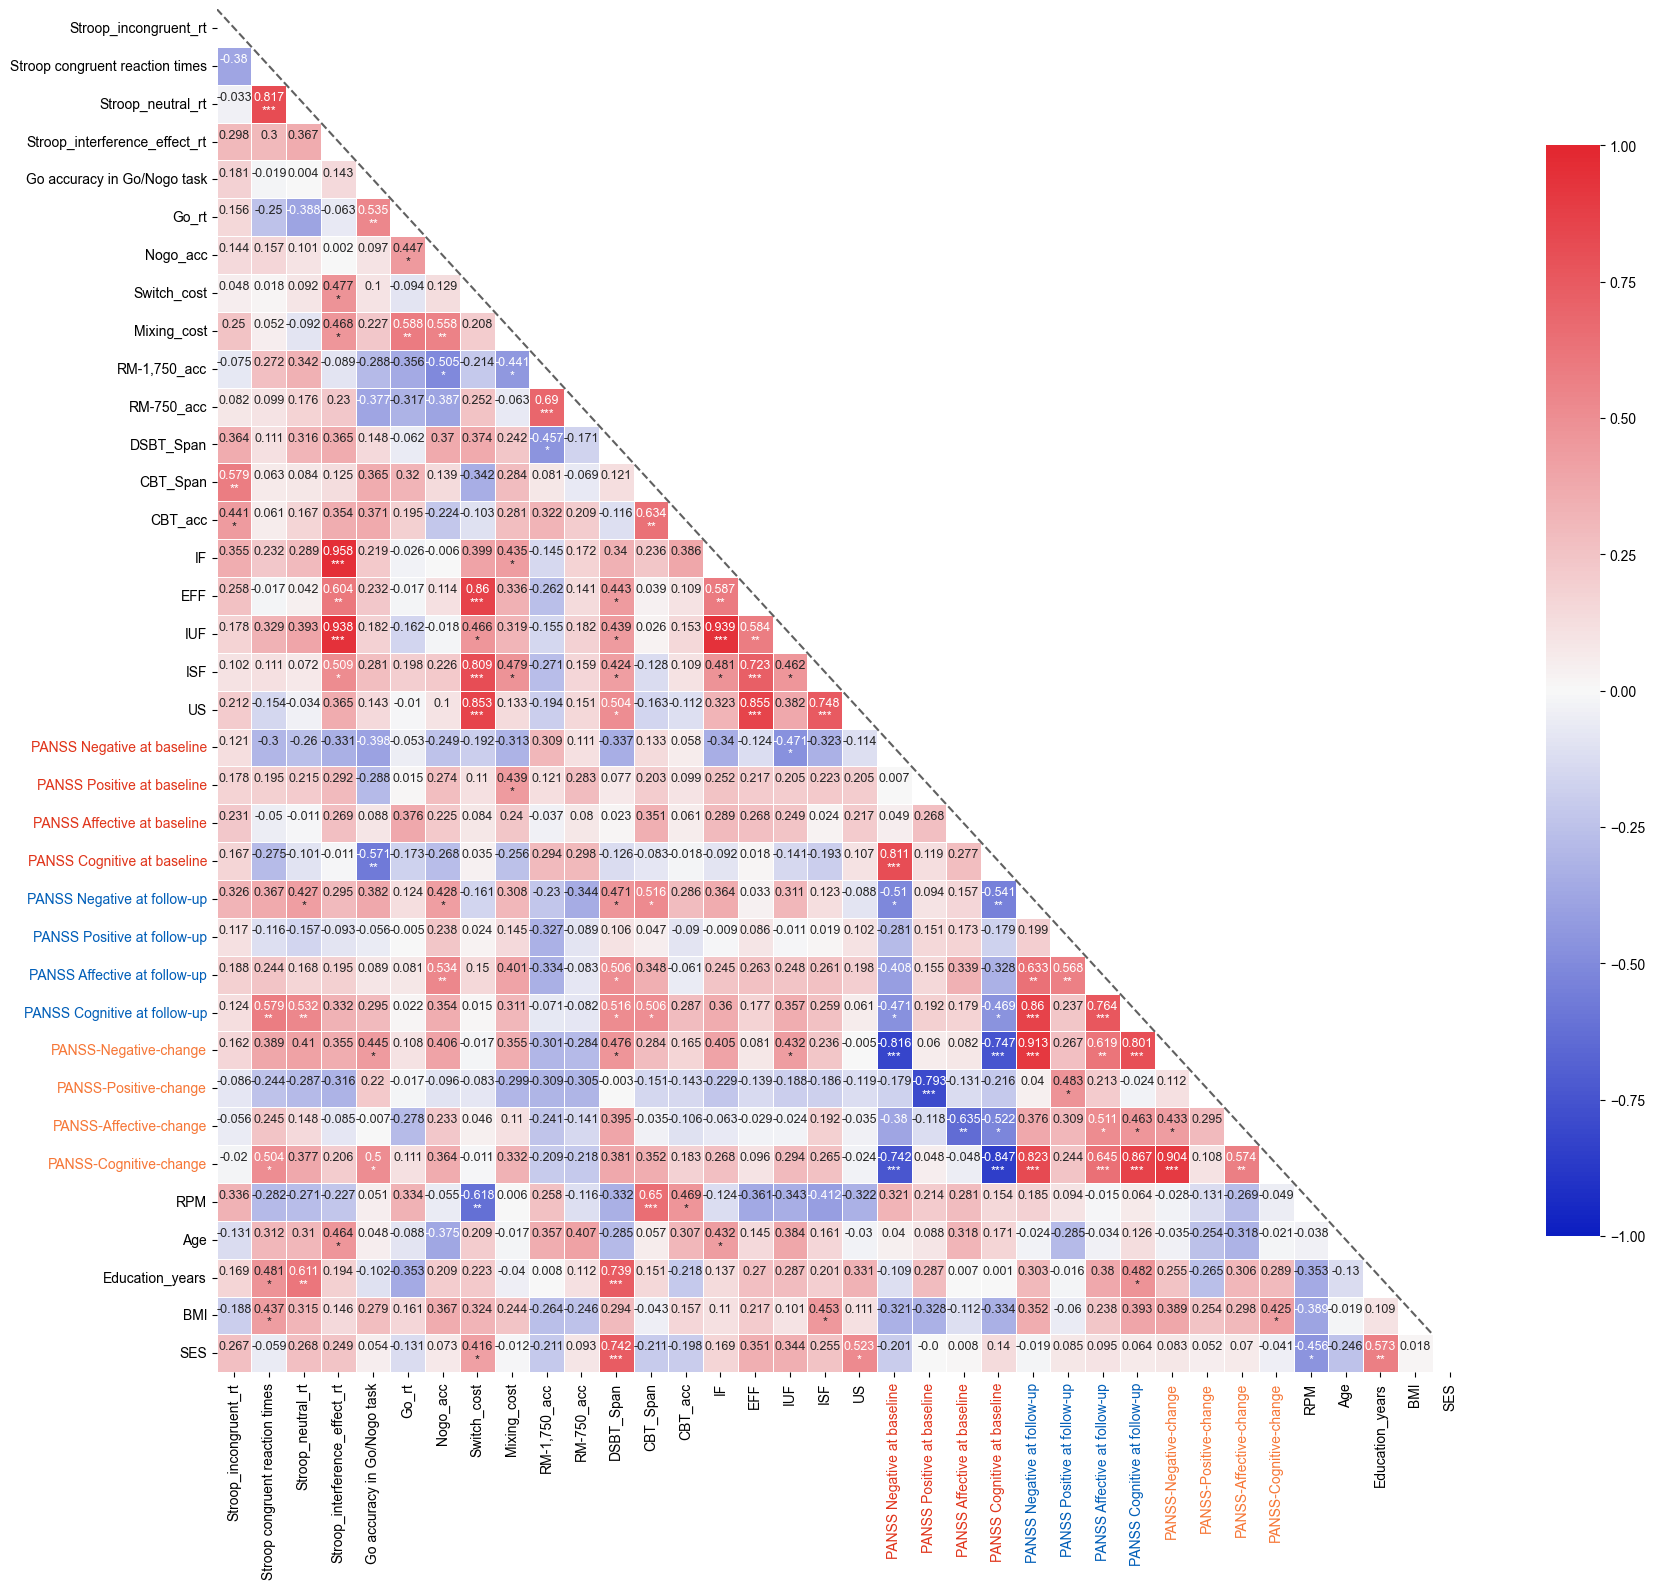

In [31]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

hex_colors_positive = ['#f7f7f7', '#E3262F']  
hex_colors_negative = ['#0C1EC1', '#f7f7f7']  

cmap_positive = LinearSegmentedColormap.from_list("Positive", hex_colors_positive, N=256)
cmap_negative = LinearSegmentedColormap.from_list("Negative", hex_colors_negative, N=256)


colors = np.vstack((cmap_negative(np.linspace(0, 1, 128)), cmap_positive(np.linspace(0, 1, 128))))
cmap_combined = LinearSegmentedColormap.from_list('Combined', colors)

data = df
corr = data[continuous_columns].corr()

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues = calculate_pvalues(data[continuous_columns])

def significance_level(pval):
    if pval < 0.001: return '***'
    elif pval < 0.01: return '**'
    elif pval < 0.05: return '*'
    else: return ''

labels = corr.round(3).astype(str) + '\n' + pvalues.applymap(significance_level)

mask = np.triu(np.ones_like(corr, dtype=bool))

np.fill_diagonal(corr.values, 0)

fig, ax = plt.subplots(figsize=(18, 16))

sns.heatmap(corr, mask=mask, cmap=cmap_combined, center=0, annot=labels, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 9})


xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

def color_labels(labels):
    for label in labels:
        text = label.get_text()
        if text in ['PANSS Negative at baseline', 'PANSS Positive at baseline', 'PANSS Affective at baseline', 'PANSS Cognitive at baseline']:
            label.set_color('#E0341A') 
        elif text in ['PANSS Negative at follow-up', 'PANSS Positive at follow-up', 'PANSS Affective at follow-up', 'PANSS Cognitive at follow-up']:
            label.set_color('#005EB8') 
        elif text in ["PANSS-Negative-change",
    "PANSS-Positive-change",
    "PANSS-Affective-change",
    "PANSS-Cognitive-change"]:
            label.set_color('#F67737')  

            
            
color_labels(xticklabels)
color_labels(yticklabels)

plt.plot(range(len(corr)), range(len(corr)), color='#606060', linestyle='dashed')

plt.tight_layout()
plt.savefig("./SHAP_correlation_result/分类预后SHAP与基线PANSS的相关分析-预后-EF+人口-所有样本.jpg", dpi=100, bbox_inches='tight')
plt.show()

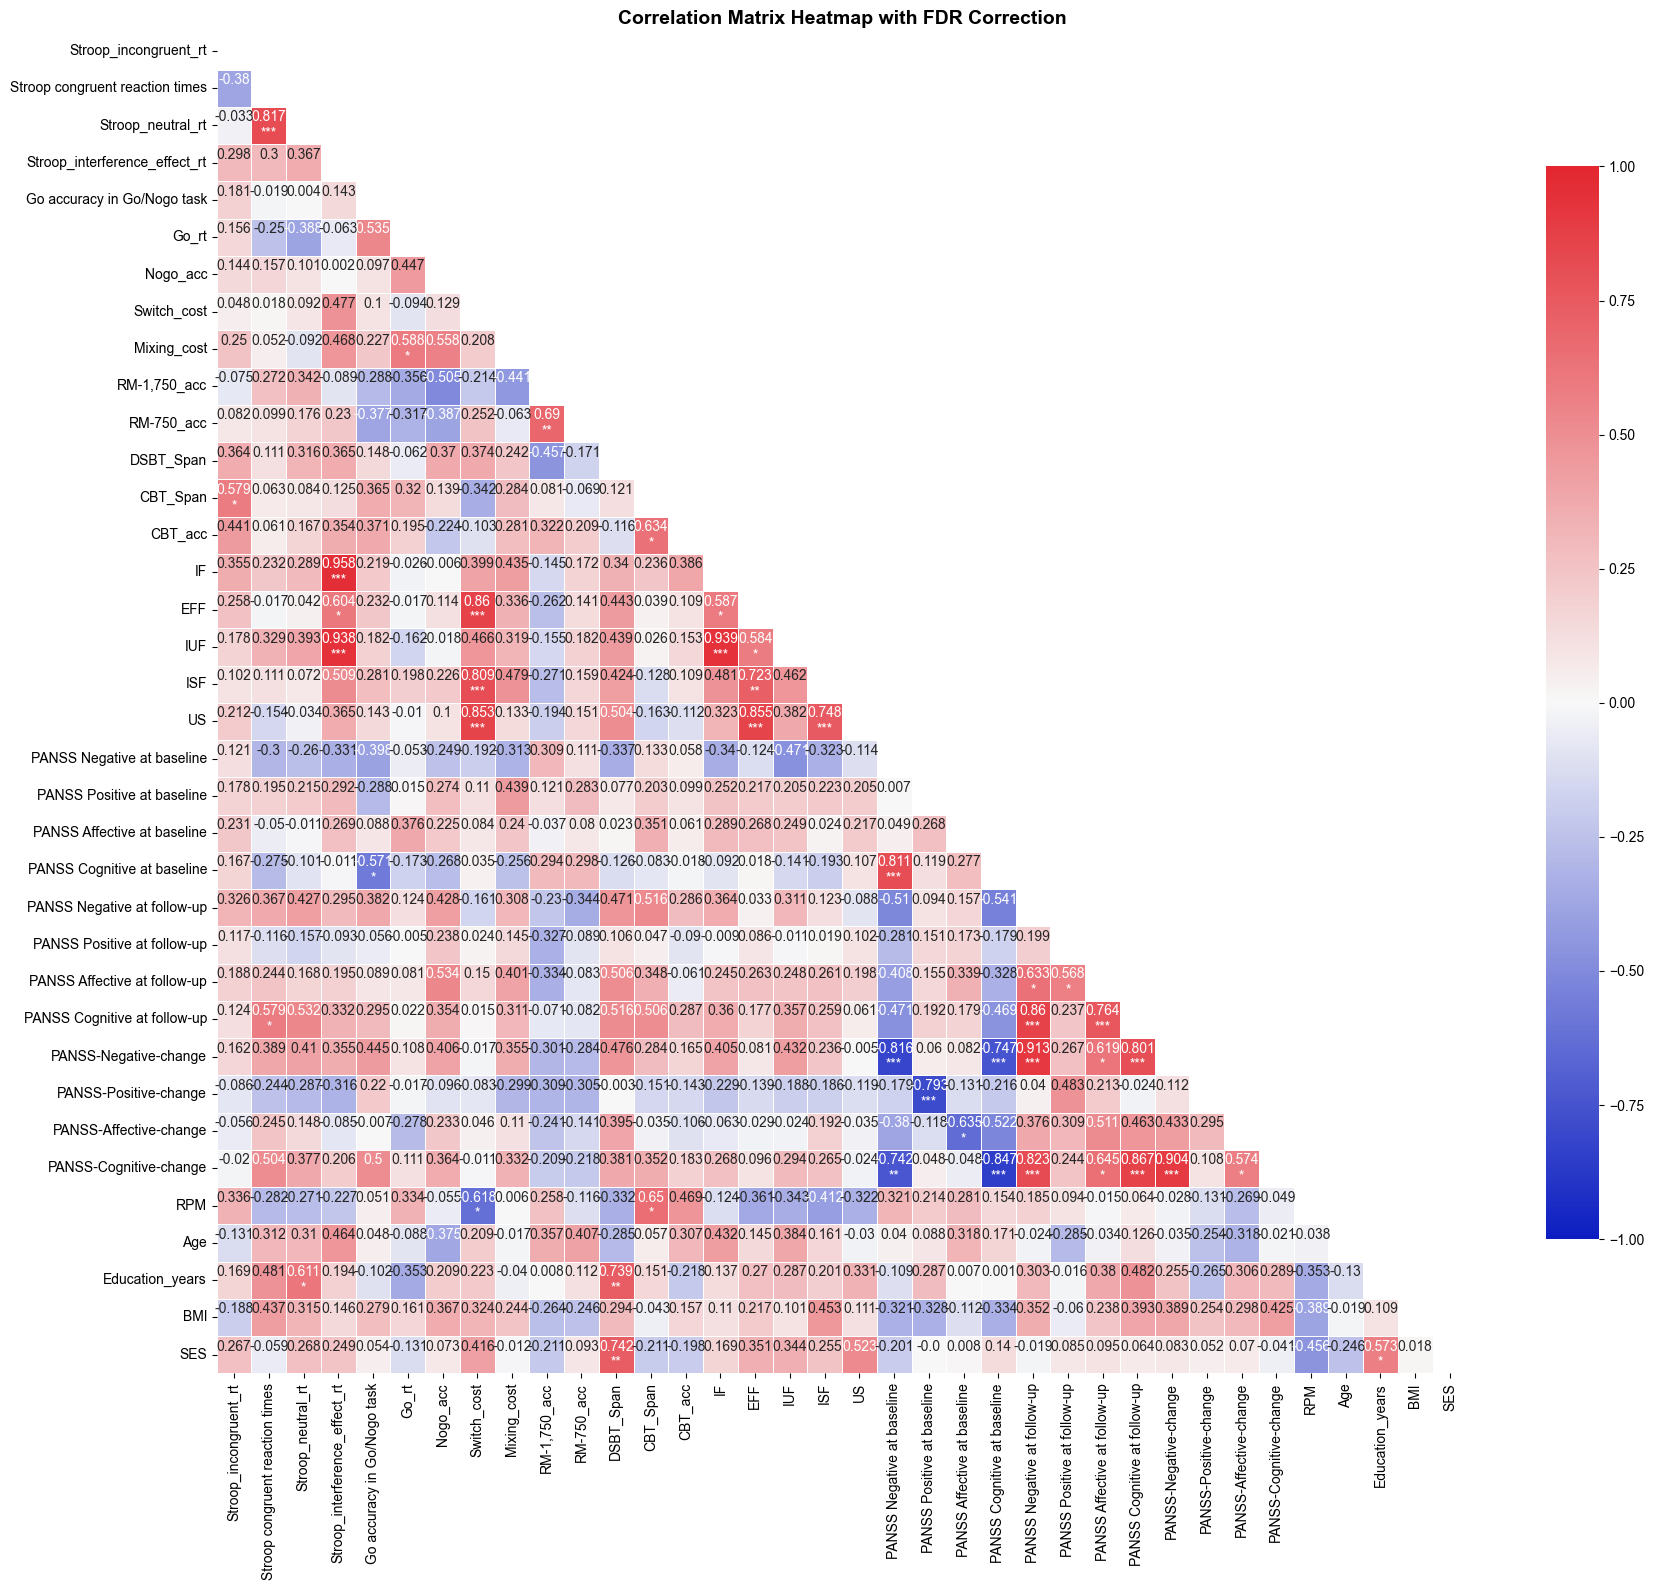

In [32]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

pvalues_numeric = pvalues.apply(pd.to_numeric, errors='coerce')

all_pvalues = pvalues_numeric.values.flatten()
all_pvalues = all_pvalues[~np.isnan(all_pvalues)]  

rej, pval_corr, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')


pval_corr_matrix = pd.DataFrame(np.reshape(pval_corr, pvalues.shape), columns=pvalues.columns, index=pvalues.index)


labels_corr = corr.round(3).astype(str) + '\n' + pval_corr_matrix.apply(lambda x: x.map(significance_level))

fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corr, mask=mask, cmap=cmap_combined, center=0, annot=labels_corr, fmt='', linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10})
ax.set_title('Correlation Matrix Heatmap with FDR Correction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("./SHAP_correlation_result/分类预后SHAP与基线PANSS的相关分析-预后-EF+人口-所有样本（包括错误预测的）_FDR.jpg", dpi=100, bbox_inches='tight')
plt.show()

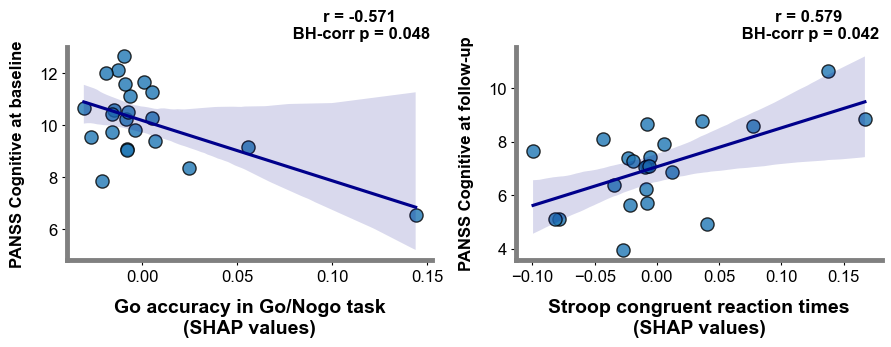

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

variables_of_interest =  ['PANSS Negative at baseline', 'PANSS Positive at baseline', 'PANSS Affective at baseline', 'PANSS Cognitive at baseline', 
                          'PANSS Negative at follow-up', 'PANSS Positive at follow-up', 'PANSS Affective at follow-up', 'PANSS Cognitive at follow-up',
    "PANSS-Negative-change",
    "PANSS-Positive-change",  
    "PANSS-Affective-change",
    "PANSS-Cognitive-change"]


significant_vars = []

for var in variables_of_interest:
    significant_vars.extend(pval_corr_matrix.loc[(pval_corr_matrix[var] < 0.05) & (pval_corr_matrix.index != var), var].index.tolist())

significant_vars = list(set(significant_vars) - set(variables_of_interest))

num_plots = len(variables_of_interest) * len(significant_vars)
num_rows = 5  

fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))  
axes = axes.flatten()
plot_idx = 0

for var2 in variables_of_interest:
    for var1 in significant_vars:
        paired_data = data[[var2, var1]].dropna()

        corrected_p = pval_corr_matrix.loc[var1, var2]
        if corrected_p < 0.05:
            ax = axes[plot_idx]
            plot_idx += 1
            sns.regplot(
                x=paired_data[var1], 
                y=paired_data[var2],
                scatter_kws={'alpha': 0.8, 's': 90, 'edgecolor': 'k'}, 
                line_kws={'color': 'darkblue'}, 
                ci=95,  
                ax=ax  
            )
            r, _ = pearsonr(paired_data[var1], paired_data[var2]) 
            p_value_str = "p < 0.001" if corrected_p < 0.001 else f"p = {corrected_p:.3f}"

            xpos = 0.80
            ypos = 1.1

            ax.text(xpos, ypos, f'r = {r:.3f}\n BH-corr {p_value_str}', fontsize=12, weight='bold', ha='center', va='center', transform=ax.transAxes)
            ax.set_ylabel(var2, fontsize=12, weight='bold', labelpad=10)
            ax.set_xlabel(f"{var1}\n(SHAP values)", fontsize=14, weight='bold', labelpad=10)

            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

            ax.spines['left'].set_linewidth(3.5)
            ax.spines['left'].set_color('grey')
            ax.spines['bottom'].set_linewidth(3.5)
            ax.spines['bottom'].set_color('grey')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig("./SHAP_correlation_result/散点图-预后-EF+社会人口-所有样本（包括错误预测的）_FDR.jpg", dpi=1000, bbox_inches='tight')
plt.show()

## 全部完成

In [34]:
print("Sucess!")

Sucess!
